In [2]:
import torch
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import numpy as np
import math
import matplotlib.pyplot as plt

class Gaussian2DDataset(Dataset):
    def __init__(self, size=128, img_dim=1000, testing = False):
        self.size = size
        self.img_dim = img_dim
        self.testing = testing
        self.images = []  # List to store generated images


    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        middle = torch.rand(2) * 700  + 100   # random middle pt

        middle=torch.abs(middle)
        cov = torch.randn(2)/2 * 64 / 2 + 64 / 2 + 1e-3  # random covariance
        cov=torch.abs(cov)
        theta = torch.randn(1) * math.pi +1e-6 # random rotation angle

        x = torch.arange(self.img_dim, dtype=torch.float32).reshape(-1, 1).repeat(1, self.img_dim)
        

        y = torch.arange(self.img_dim, dtype=torch.float32).reshape(1, -1).repeat(self.img_dim, 1)
        

        rota_matrix = torch.tensor([[torch.cos(theta), -torch.sin(theta)],
                                    [torch.sin(theta), torch.cos(theta)]])

        xy = torch.stack([x, y], dim=2)- middle  # shift to mean
       
        xy = torch.einsum('ijk,kl->ijl', xy, rota_matrix)  # rotation


        img = torch.exp(-0.5 * (xy[:, :, 0]**2 / (cov[0]**2+1e-3) + xy[:, :, 1]**2 / (cov[1]**2+1e-3)))


        img_rgb = torch.cat((img.unsqueeze(0), img.unsqueeze(0), img.unsqueeze(0)), dim=0)  # Convert to RGB, resnet34 takes 3 color channels, our image is grey

        img_rgb = img_rgb / img_rgb.max()
        self.images.append(img_rgb)

        bbox = {
        'center_x': middle[1],
        'center_y': middle[0],
        'width': 5 * cov[1],
        'height': 5 * cov[0],
        'theta': theta
        }
        
        # return img_rgb, (middle, cov, theta, bbox)

        return img_rgb,bbox

dataset = Gaussian2DDataset(size=1, img_dim=1000, testing=True)

image, bbox = dataset[0]
print(bbox)

{'center_x': tensor(603.4523), 'center_y': tensor(272.8586), 'width': tensor(251.9849), 'height': tensor(271.0609), 'theta': tensor([3.7546])}


{'center_x': tensor(458.6346), 'center_y': tensor(751.0139), 'width': tensor(13.2586), 'height': tensor(254.0483), 'theta': tensor([-4.2308])}
{'center_x': tensor(648.9059), 'center_y': tensor(693.9529), 'width': tensor(45.8537), 'height': tensor(237.1745), 'theta': tensor([6.5287])}
{'center_x': tensor(729.2851), 'center_y': tensor(155.5556), 'width': tensor(116.6355), 'height': tensor(245.6282), 'theta': tensor([-3.8738])}
Bounding Box: center_x=458.63458251953125, center_y=751.0138549804688, width=13.258554458618164, height=254.04833984375
Bounding Box: center_x=648.9058837890625, center_y=693.9529418945312, width=45.853668212890625, height=237.17446899414062
Bounding Box: center_x=729.2850952148438, center_y=155.55560302734375, width=116.63545227050781, height=245.62823486328125


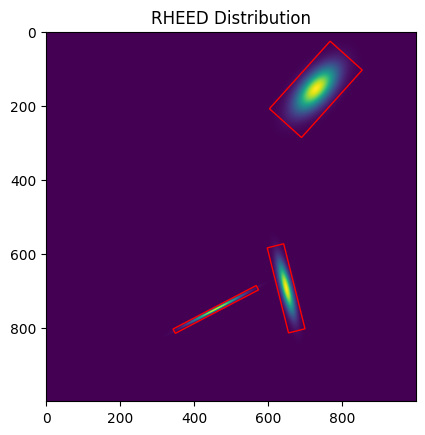

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt



def generate_rheed_images(num_images, grid_size, img_dim):
    # Generate random coordinates
    coordinates = torch.randint(low=0, high=grid_size - img_dim + 1, size=(num_images, 2))

    rheed_grid = np.zeros((grid_size, grid_size))  # Initialize the RHEED grid
    bboxes = []
    # Generate Gaussian images and add them to the RHEED grid
    for i in range(num_images):
        # Generate a single Gaussian image
        dataset = Gaussian2DDataset(size=1, img_dim=img_dim)
        image, bbox = dataset[0]
        print(bbox)

        x, y = coordinates[i]
        rheed_grid[x:x+img_dim, y:y+img_dim] = np.add(rheed_grid[x:x+img_dim, y:y+img_dim], image[0])  # Add the Gaussian image to the RHEED grid
        bboxes.append(bbox)
        
    rheed_grid /= np.max(rheed_grid)
    return rheed_grid, bboxes

# Parameters
num_images = 3
grid_size = 1000
img_dim = 1000

# Generate RHEED images
rheed_images,bboxes = generate_rheed_images(num_images, grid_size, img_dim)

# Display the RHEED images
fig, ax = plt.subplots()
ax.imshow(rheed_images, cmap='viridis')
ax.set_title('RHEED Distribution')

for bbox in bboxes:
    center_x = bbox['center_x']
    center_y = bbox['center_y']
    width = bbox['width']
    height = bbox['height']
    theta=-math.degrees(bbox['theta'])
    rect = plt.Rectangle((center_x - width/2, center_y - height/2), width, height,angle= theta, rotation_point='center', edgecolor='red', facecolor='none')
    ax.add_patch(rect)
    print(f"Bounding Box: center_x={center_x}, center_y={center_y}, width={width}, height={height}")

plt.savefig('rheed generator')
plt.show()

